# GeoCluster 1st hierarchy

Load required libraries and initiate basic objects.

In [1]:
# External libraries.
import torch
import numpy as np
import matplotlib.pyplot as plt
# Internal libraries.
from src.utils.data import loadData
from src import visualization as vis
from src.utils import plot_tools as pt

/home/dell/anaconda3/envs/GeoCluster/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Loading data...
Data loaded.
[100.         290.           1.           0.35545887]


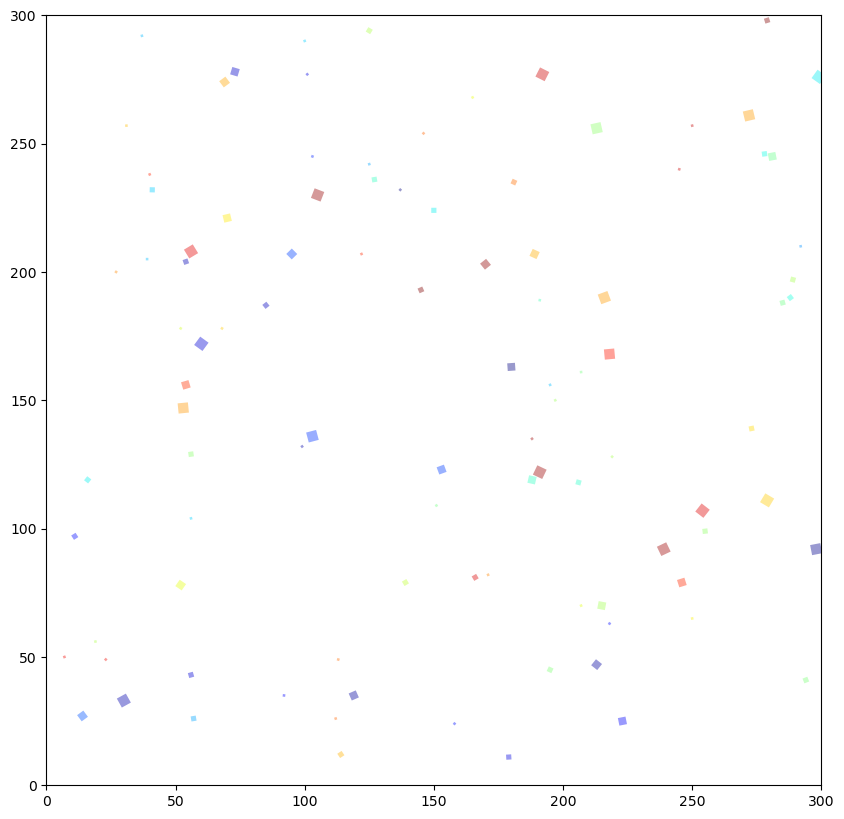

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load data.
squares, _ = loadData(100)
print(squares[0])
vis.plot_data(squares, limits=[0, 300, 0, 300])

## Training Teacher

In [3]:
# from src.models import LVGEBM

# teacher = LVGEBM(4, 2, 400).to(device)
# learning_rate = 1e-2
# teacher.train_(optimizer=torch.optim.Adam(teacher.parameters(), lr=learning_rate),
#                epochs=200,
#                times=10,
#                train_data=torch.from_numpy(squares).float().to(device),
#                alpha=5,
#                beta=10)

# # Save best model state to .pt format.
# torch.save(teacher.best_model_state, "models/squares/100/teacher_config.pt")
# print("Saved teacher config to models/squares/100/teacher_config.pt")

# # Save training results to .npy format.
# teacher_results = {
#     "best_model": teacher.best_model_state,
#     "best_outputs": teacher.best_outputs,
#     "best_z": teacher.best_z,
#     "best_lat": teacher.best_lat,
#     "best_epoch": teacher.best_epoch,
#     "p_p": teacher.p_p,
#     "p_c": teacher.p_c,
#     "reg_proj_array": teacher.reg_proj_array,
#     "reg_latent_array": teacher.reg_latent_array,
#     "memory": teacher.memory,
#     "cost_array": teacher.cost_array
# }
# np.save("models/squares/100/teacher_training_results.npy", teacher_results)
# print("Saved teacher training results to models/squares/100/teacher_training_results.npy")

In [4]:
# Load model from configuration (no need to train each time).
# WARNING: Training results in model object will be reset, run next cell to reload.
from src.models import LVGEBM
teacher = LVGEBM(4, 2, 400).to(device)
teacher.load_state_dict(torch.load("models/squares/100/teacher_config.pt"))
teacher.eval()
print("Loaded teacher config from models/squares/100/teacher_config.pt")

Loaded teacher config from models/squares/100/teacher_config.pt


In [5]:
# Load the training results (optional in general, necessary for following cells).
teacher_results = np.load("models/squares/100/teacher_training_results.npy", allow_pickle=True)
for name, value in teacher_results.item().items():
    setattr(teacher, name, value)
print("Loaded teacher training results from models/squares/100/teacher_training_results.pt")

Loaded teacher training results from models/squares/100/teacher_training_results.pt


Load and print some important variables.

In [6]:
print("best epoch: ", teacher.best_epoch)
print("best outputs: ", teacher.best_outputs)
# print("costs: ", teacher.cost_array)
train_data=torch.from_numpy(squares).float().to(device)
unique_clusters = torch.unique(teacher.best_z)
data_for_clusters = []
for cluster in unique_clusters:
    print(cluster)
    cluster_data = train_data[teacher.best_z == cluster]
    data_for_clusters.append(cluster_data)

print(len(data_for_clusters))

# print(unique_clusters.numel())
# for data in data_for_clusters:
#     print(data)

print(type(teacher.best_z))


best epoch:  34
best outputs:  tensor([[169.0256, 224.4710],
        [204.2634,  94.4493],
        [ 53.0265, 187.1879],
        [202.2481, 226.2831]], requires_grad=True)
tensor(0)
tensor(1)
tensor(2)
tensor(3)
4
<class 'torch.Tensor'>


In [7]:
from src import quadtree as qt
from src.models import Voronoi

threshold = 5
# data=torch.from_numpy(squares).float().to(device)
learning_rate = 1e-2
teacher_args = {
    "optimizer": torch.optim.Adam(teacher.parameters(), lr=learning_rate),
    "optimizer_lr": learning_rate,
    "epochs": 200,
    "times": 10,
    "train_data": torch.from_numpy(squares).float().to(device),
    "alpha": 5,
    "beta": 10
}

sensitivity=0.15
un_args = {      #"teacher_best_outputs": teacher.best_outputs.cpu().detach().numpy(),
    "N": 100,
    "M": 10000 - 1,
    "epsilon": sensitivity,
    "x_area": [0, 300],
    "y_area": [0, 300],
    "model": teacher
}

student = Voronoi(4, 2, 2).to(device) 
epochs=30000
learning_rate = 1e-3
student_args = {
    "optimizer": torch.optim.Adam(student.parameters(), lr=1e-3),
    "optimizer_lr": learning_rate,
    "epochs": epochs,
    "device": device,
}

qTree = qt.QuadTree(threshold, squares, teacher_args, un_args, student_args)


Training Teacher Model
Epoch: 20/200..  Training loss: 8617.50293..  Reg Proj: 0.00000..  Reg Latent: 0.72472..  Memory: 8610.25586..  Cost: 8617.50293.. 
Epoch: 40/200..  Training loss: 7957.24365..  Reg Proj: 0.00000..  Reg Latent: 0.17804..  Memory: 7955.46338..  Cost: 7957.24365.. 
Epoch: 60/200..  Training loss: 7743.10645..  Reg Proj: 0.00000..  Reg Latent: 0.19965..  Memory: 7741.10986..  Cost: 7743.10645.. 
Epoch: 80/200..  Training loss: 7249.96582..  Reg Proj: 0.00000..  Reg Latent: 0.08755..  Memory: 7249.09033..  Cost: 7249.96582.. 
Epoch: 100/200..  Training loss: 7624.17969..  Reg Proj: 0.00000..  Reg Latent: 0.58975..  Memory: 7618.28223..  Cost: 7624.17969.. 
Epoch: 120/200..  Training loss: 10588.16992..  Reg Proj: 0.00000..  Reg Latent: 0.31245..  Memory: 10585.04590..  Cost: 10588.16992.. 
Epoch: 140/200..  Training loss: 9633.08398..  Reg Proj: 0.00000..  Reg Latent: 0.36228..  Memory: 9629.46094..  Cost: 9633.08398.. 
Epoch: 160/200..  Training loss: 8632.27051..  

KeyError: 'optimizer_lr'

Plot results

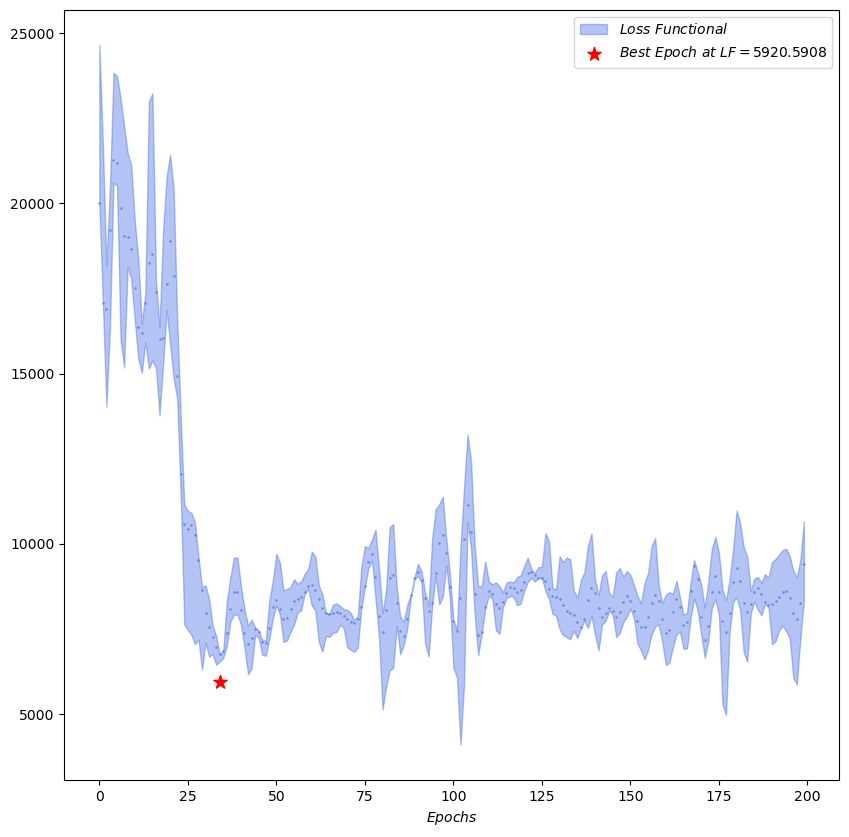

In [16]:
# Plot the Amplitude demodulation of the signal (costs array).
signal = teacher.cost_array
upper_signal, lower_signal, filtered_signal = pt.AM_dem(signal, fc=0.4*len(signal), fs=2*len(signal))
pt.plot_AM_dem(upper_signal, lower_signal, filtered_signal, signal, teacher.best_epoch)

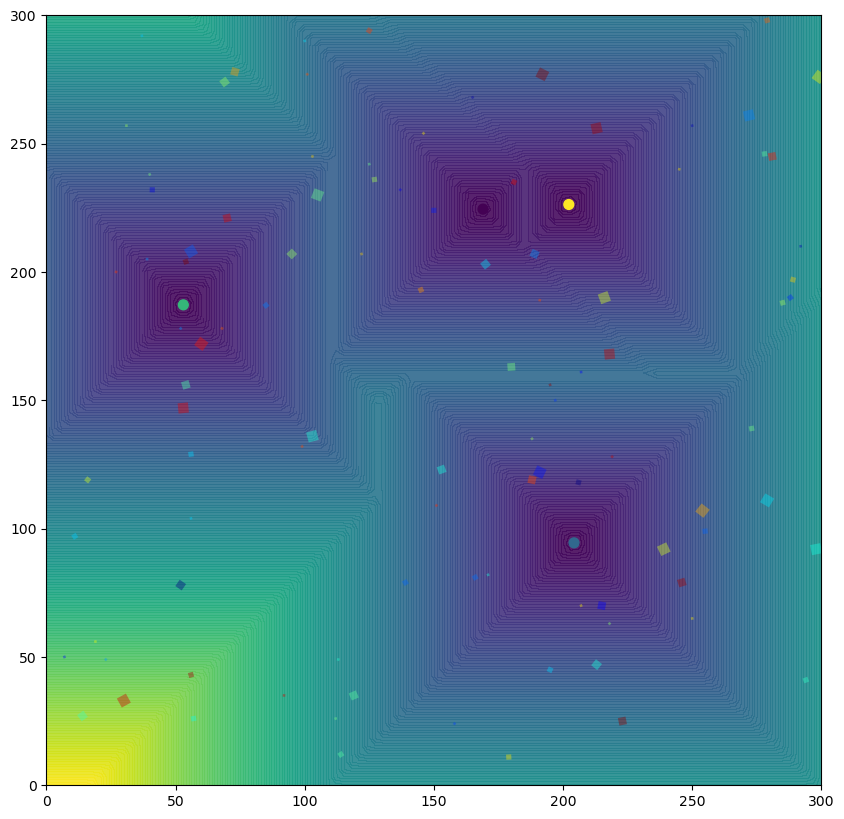

In [17]:
# Plot the best model with the best outputs.
manifold = pt.createManifold(teacher, teacher.best_outputs.cpu())
pt.plotManifold(squares, manifold, teacher.best_outputs.cpu(), [0, 300], [0, 300])

## Uncertainty Area

Predicting...
Processing...
flag is 4139
m is 5862
i is 10000
Points sampled:  5862


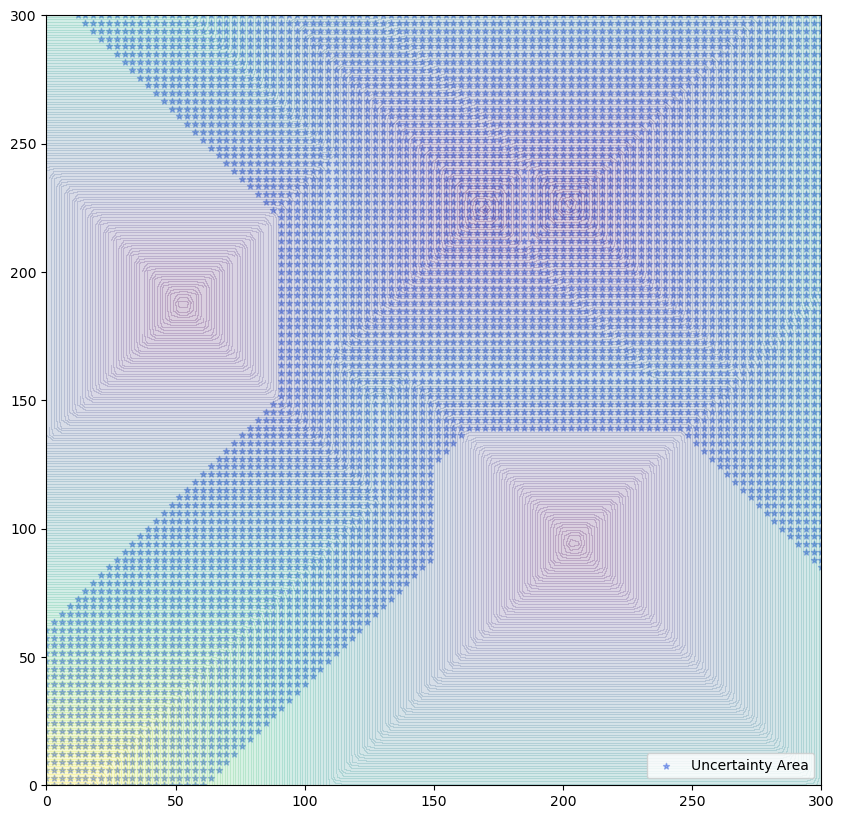

In [18]:
from src.utils.functions import getUncertaintyArea

sensitivity = 0.15
print('Predicting...')
m_points = getUncertaintyArea(teacher.best_outputs.cpu().detach().numpy(),
                              N=100,
                              M=10000-1,
                              epsilon=sensitivity,
                              x_area=[0,300],
                              y_area=[0,300],
                              model=teacher)
print('Points sampled: ', len(m_points))

# Plot the m points that are in the uncertainty area.
m_points = np.array(m_points)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(m_points[:, 0], m_points[:, 1], s=20, c='royalblue', alpha=0.5, marker='*', label='Uncertainty Area')
ax.contourf(manifold[:, :, 0], manifold[:, :, 1], manifold[:, :, 2], levels=200, cmap='viridis', alpha=0.2)
plt.legend()

## Labeling

In [19]:
from src.utils.functions import getE

qp = np.random.permutation(m_points)
qp = torch.tensor(qp)
# TODO: Pass squares to getE as an argument.
F, z, F_sq, z_sq = getE(teacher, teacher.best_outputs.cpu(), qp)

# Initialize the pseudo clusters.
# Append squares that their z_sq is i for each centroid.
pseudo_clusters = [squares[z_sq == i] for i in range(teacher.n_centroids)]

TypeError: getE() missing 1 required positional argument: 'sq'

### Create Labels

In [ ]:
from src.utils.functions import NearestNeighbour

outputs_shape = (qp.shape[0], teacher.n_centroids)
F_ps = torch.zeros(outputs_shape)
z_ps = torch.zeros(outputs_shape)
for i in range(outputs_shape[0]):
    if i % 1000 == 0:
        print(f"Labeled {i}/{outputs_shape[0]} points.")
    for j in range(outputs_shape[1]):
        qpoint = qp[i].cpu().detach().numpy()
        F_ps[i,j], z_ps[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j]))
print(f"Labeled all {outputs_shape[0]}/{outputs_shape[0]} points.")

Labeled 0/3536 points.
Labeled 1000/3536 points.
Labeled 2000/3536 points.
Labeled 3000/3536 points.
Labeled all 3536/3536 points.


### Plot labels

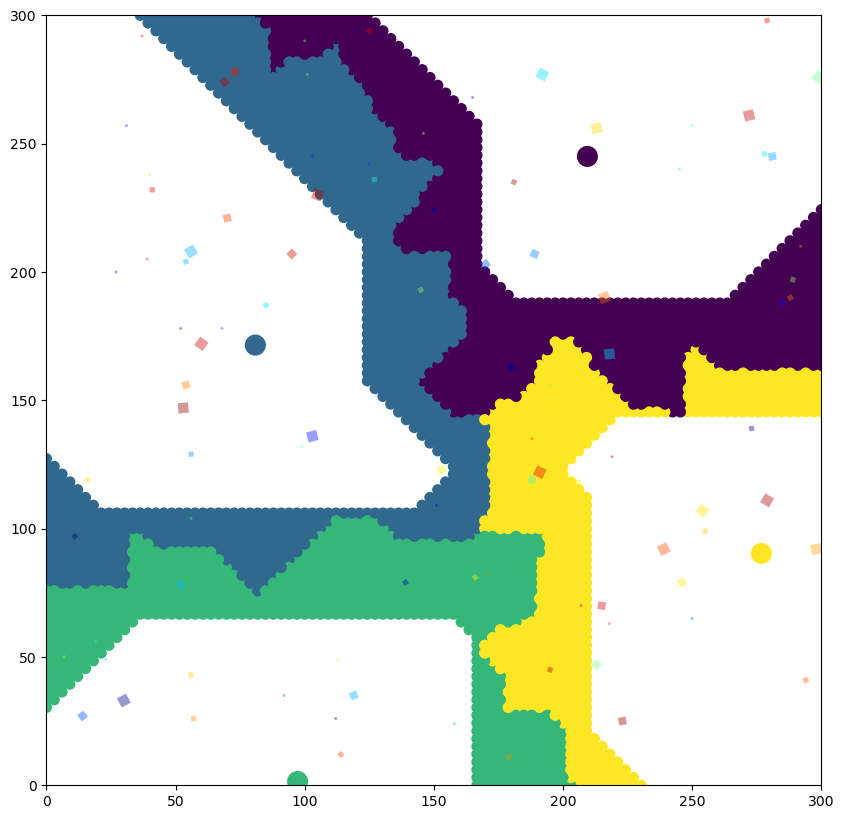

In [ ]:
# plot qp
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# labels are z
labels =  z
plt_qp = qp.cpu().detach().numpy()
new_labels = F_ps.min(1)[1].cpu().detach().numpy()
ax.scatter(plt_qp[:, 0], plt_qp[:, 1], c=new_labels, s=50)
# plot best_outputs
plt_bo = teacher.best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, teacher.best_outputs.shape[0], teacher.best_outputs.shape[0])
ax.scatter(plt_bo[:, 0], plt_bo[:, 1], c=c, s=200)
z_labels = z
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300])
# plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])

## Training Student

In [ ]:
from src.models import Voronoi

student = Voronoi(4, 2, 2).to(device) # initialize the voronoi network
epochs = 30000 # number of epochs
student.train_(optimizer=torch.optim.Adam(student.parameters(), lr=1e-3),
               epochs=epochs,
               device=device,
               qp=torch.tensor(qp), # send qp to device
               F_ps=F_ps)

# Save voronoi model.
torch.save(student.best_vor_model_state, "models/squares/100/student_config.pt")
print("Saved student config to models/squares/100/student_config.pt")

# Save training results to .npy format.
student_results = {
    "best_vor_model_state": student.best_vor_model_state,
    "cost_ll": student.cost_ll,
    "acc_l": student.acc_l,
    "es": student.es
}
np.save("models/squares/100/student_training_results.npy", student_results)
print("Saved teacher training results to models/squares/100/student_training_results.npy")

/tmp/ipykernel_5544/3252414846.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp=torch.tensor(qp), # send qp to device
/home/dell/Desktop/GeoCluster/src/models.py:272: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp).to(device)
/home/dell/Desktop/GeoCluster/src/models.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp, dtype=torch.float32).to(device)


Training Student Model
Acc:  0.22115384615384615
Epoch:  0 Cost:  2254.747314453125
Acc:  0.8173076923076923
Epoch:  2000 Cost:  40.251617431640625
Acc:  0.9021493212669683
Epoch:  4000 Cost:  24.903039932250977
Acc:  0.9519230769230769
Epoch:  6000 Cost:  18.617267608642578
Acc:  0.958710407239819
Epoch:  8000 Cost:  16.377033233642578
Acc:  0.9507918552036199
Epoch:  10000 Cost:  15.601905822753906
Acc:  0.931843891402715
Epoch:  12000 Cost:  15.891122817993164
Acc:  0.9338235294117647
Epoch:  14000 Cost:  15.213523864746094
Acc:  0.9400452488687783
Epoch:  16000 Cost:  14.107181549072266
Acc:  0.9137443438914027
Epoch:  18000 Cost:  18.20075225830078
Acc:  0.9748303167420814
Epoch:  20000 Cost:  10.605110168457031
Acc:  0.9222285067873304
Epoch:  22000 Cost:  16.438804626464844
Acc:  0.9768099547511312
Epoch:  24000 Cost:  9.877843856811523
Acc:  0.9759615384615384
Epoch:  26000 Cost:  9.649775505065918
Acc:  0.977658371040724
Epoch:  28000 Cost:  9.380579948425293
Saved student con

In [ ]:
# Load model from configuration (no need to train each time).
# WARNING: Training results in model object will be reset, run next cell to reload.
from src.models import Voronoi

student = Voronoi(4, 2, 2).to(device)
student.load_state_dict(torch.load("models/squares/100/student_config.pt"))
student.eval()
print("Loaded student config from models/squares/100/student_config.pt")

Loaded student config from models/squares/100/student_config.pt


In [ ]:
# Load the training results (optional in general, necessary for following cells).
student_results = np.load("models/squares/100/student_training_results.npy", allow_pickle=True)
for name, value in student_results.item().items():
    setattr(student, name, value)
print("Loaded student training results from models/squares/100/student_training_results.pt")

Loaded student training results from models/squares/100/student_training_results.pt


Plot Accuracy and Loss

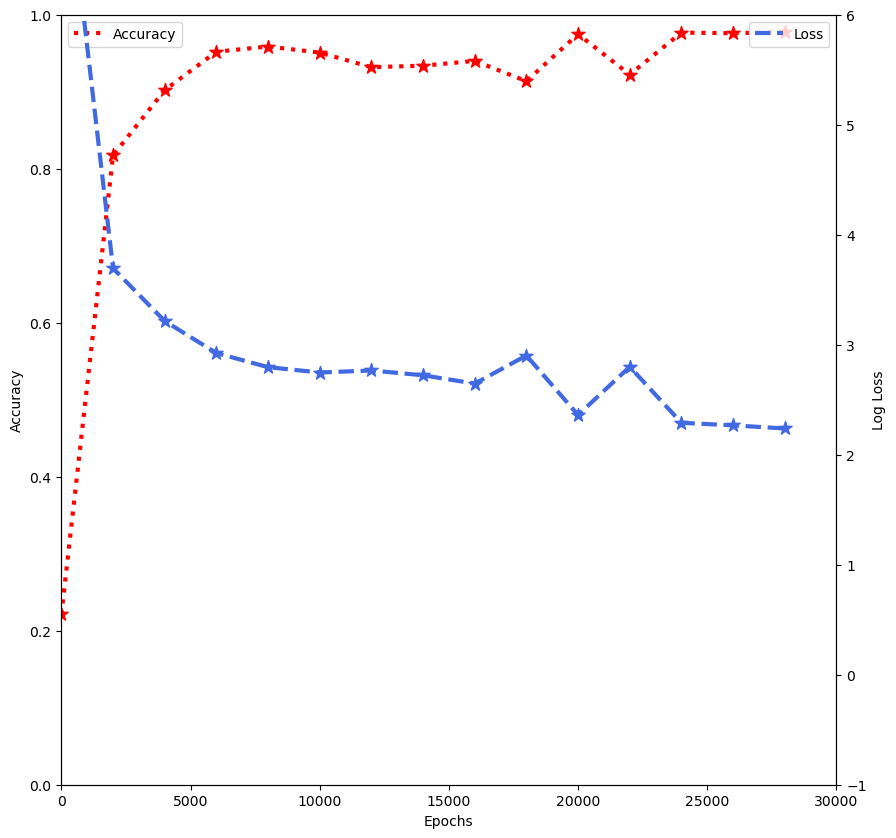

In [ ]:
student.plot_accuracy_and_loss(epochs)

## Inferencing

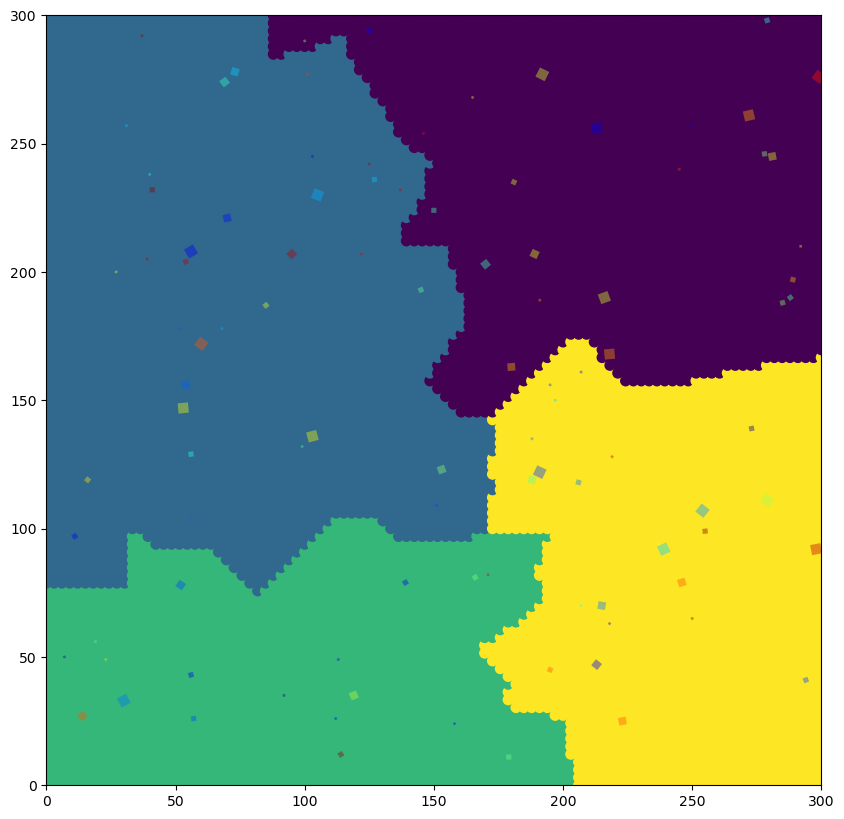

In [ ]:
# ok lets infer
infer_points = torch.zeros(10000, 2) # initialize the infer points
x_lim = [0, 300] # x limits
y_lim = [0, 300] # y limits
for i, x in enumerate(np.linspace(x_lim[0], x_lim[1], 100)): # sample 100 points in x_lim
    for j, y in enumerate(np.linspace(y_lim[0], y_lim[1], 100)): # sample 100 points in y_lim
        infer_points[i * 100 + j] = torch.Tensor([x, y]) # append the point to infer_points

infer_points = infer_points.to(device) # send infer_points to device
classes = student(infer_points) # get the classes of infer_points
infer_points = infer_points.cpu().detach().numpy() # send infer_points to cpu
classes = classes.max(1)[-1].cpu().detach().numpy() # send classes to cpu

# Plot classes.
fig = plt.figure(figsize=(10, 10)) # initialize the figure
ax = fig.add_subplot(111) # add subplot
ax.scatter(infer_points[:, 0], infer_points[:, 1], c=classes, s=50) # plot infer_points
# plot scatter of output = model(model.z)
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300]) # plot sq

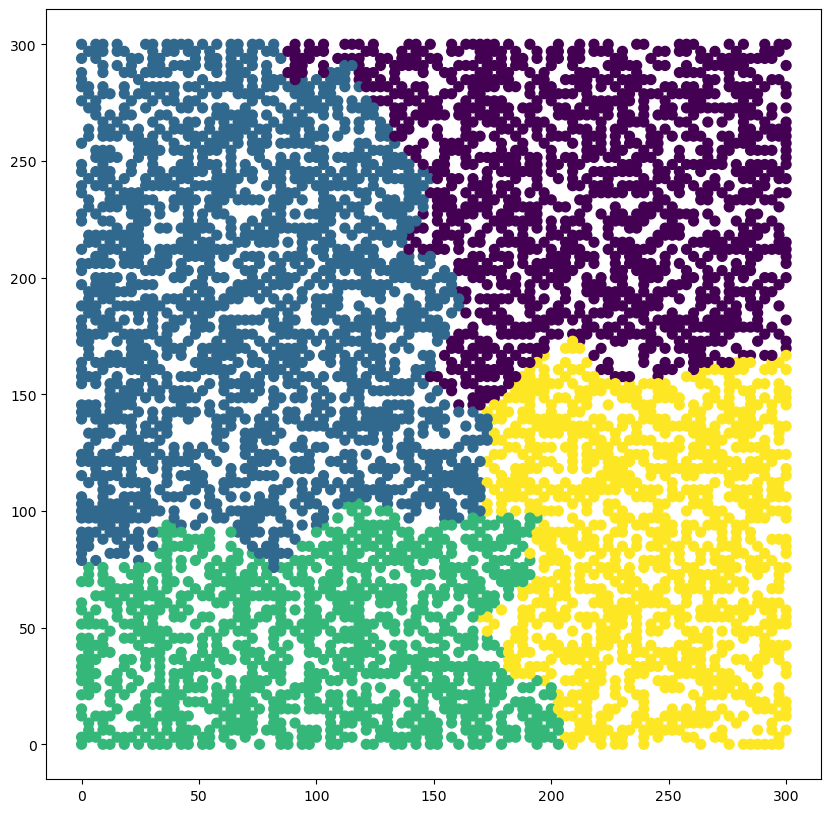

In [ ]:
# Take 5000 randomly of those 10000 points randomly in [0,300]x[0,300].
infer_points = torch.from_numpy(infer_points)
infer_points = infer_points[torch.randperm(infer_points.shape[0])][:5000]
infer_points = infer_points.to(device)
classes = student(infer_points)
z = classes.max(1)[-1].cpu().detach().numpy()
infer_points = infer_points.cpu().detach().numpy()
# plot infer_points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(infer_points[:, 0], infer_points[:, 1], c=z, s=50)

### Randomly inferred points.

In [ ]:
outputs_shape = (infer_points.shape[0], teacher.n_centroids) # initialize outputs shape
F_ps_infer = torch.zeros(outputs_shape) # initialize F_ps
z_ps_infer = torch.zeros(outputs_shape) # initialize z_ps
for i in range(outputs_shape[0]): # for each infer point
    if i % 1000 == 0: # print every 1000 points
        print(f"Labeled {i}/{outputs_shape[0]} points.")
    for j in range(outputs_shape[1]): # for each pseudo cluster
        qpoint = infer_points[i] # get the infer point
        F_ps_infer[i, j], z_ps_infer[i, j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j])) # get the Linf distance between the infer point and the pseudo cluster

print(f"Labeled all {outputs_shape[0]}/{outputs_shape[0]} points.")
z_i = F_ps_infer.min(1)[1].cpu().detach().numpy() # get the z_i

Labeled 0/5000 points.
Labeled 1000/5000 points.
Labeled 2000/5000 points.
Labeled 3000/5000 points.
Labeled 4000/5000 points.
Labeled all 5000/5000 points.


Get Accuracy

In [ ]:
# get all the number of times z == z_i
times = [z == z_i]
print(np.sum(times) / z.shape[0])
print("Number of false predictions: ", z.shape[0] - np.sum(times))

0.9804
Number of false predictions:  98


Plot points.

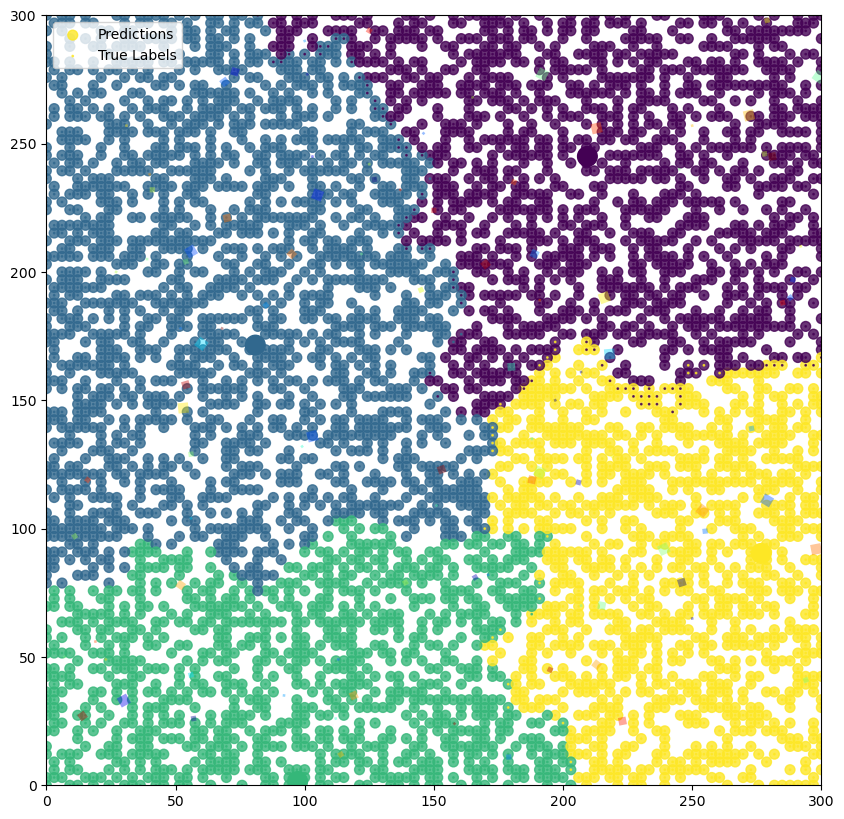

In [ ]:
fig = plt.figure(figsize=(10, 10)) # initialize the figure
ax = fig.add_subplot(111) # add subplot
infer_points_plt = infer_points # infer_points
#z = z
classes_ = z # z
ax.scatter(infer_points_plt[:, 0], infer_points_plt[:, 1], c=z, s=50, label='Predictions', alpha=0.8) # plot infer_points
# plot z_i labels
# color
classes_ = z_i # z_i
ax.scatter(infer_points_plt[:, 0], infer_points_plt[:, 1], c=classes_, s=1, label='True Labels', alpha=0.8) # plot infer_points
ax.set_xlim([0, 300])
ax.set_ylim([0, 300])
# plot legend
plt.legend(scatterpoints=1, loc='upper left', fontsize=10)
# also vis data
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300])
# plot best_outputs
plt_bo = teacher.best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, teacher.best_outputs.shape[0], teacher.best_outputs.shape[0])
ax.scatter(plt_bo[:, 0], plt_bo[:, 1], c=c, s=200)